In [1]:
# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

In [51]:
#where folder is stored
folder_path = '../../data/maya_diffusion/2023-05-19_atpcal_iATP_Maya_1/'
include = '*0001*.tif'
#find file names
files = np.sort(glob.glob(folder_path+include))
#convert file names to images
ims = []
for file in files:
    im = skimage.io.imread(file).astype(np.int16)
    ims.append(im)
#make image list an array and delete the zero ATP condition (last index)
ims = ims[:-1]

#import non-spotty zero data
zero_path = '../../data/maya_diffusion/2023-05-19_atpcal0ATP_iATP_Maya_1/'
include = '2023-05-19_atpcal0ATP_iATP_Maya_1_MMStack_Pos2.ome0001.tif'
zeroim = skimage.io.imread(zero_path+include).astype(np.int16)
ims.append(zeroim)

ims=np.array(ims)

In [52]:
np.shape(ims)

(8, 1200, 1920)

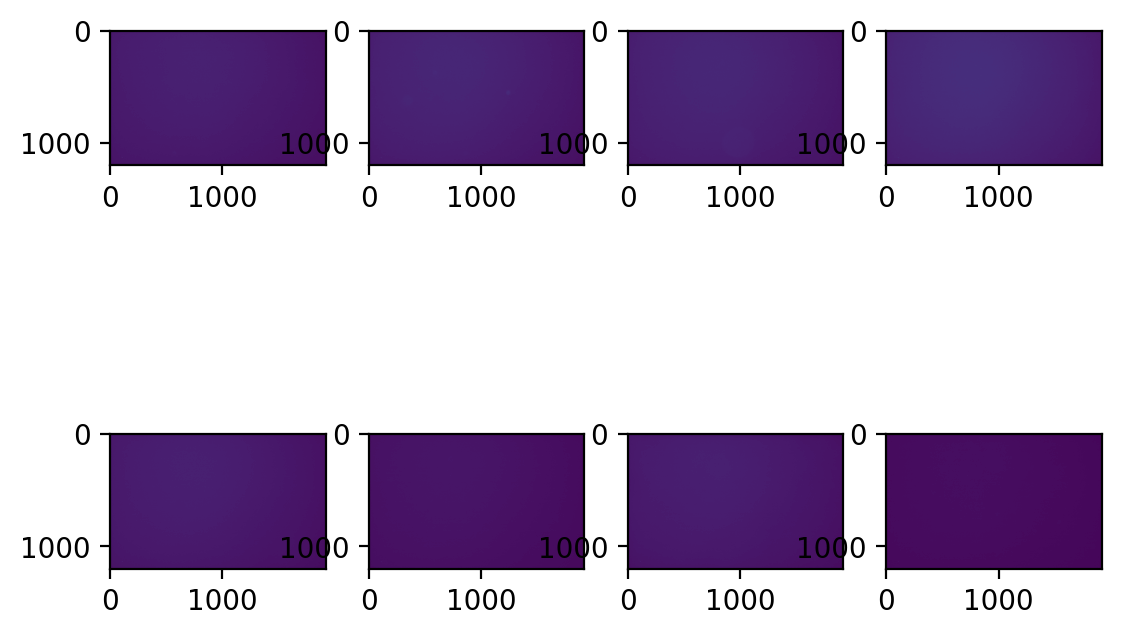

In [53]:
fig, ax = plt.subplots(2, 4)
ax[0][0].imshow(ims[0], vmin = ims.min(), vmax = ims.max())
ax[0][1].imshow(ims[1], vmin = ims.min(), vmax = ims.max())
ax[0][2].imshow(ims[2], vmin = ims.min(), vmax = ims.max())
ax[0][3].imshow(ims[3], vmin = ims.min(), vmax = ims.max())
ax[1][0].imshow(ims[4], vmin = ims.min(), vmax = ims.max())
ax[1][1].imshow(ims[5], vmin = ims.min(), vmax = ims.max())
ax[1][2].imshow(ims[6], vmin = ims.min(), vmax = ims.max())
ax[1][3].imshow(ims[7], vmin = ims.min(), vmax = ims.max())

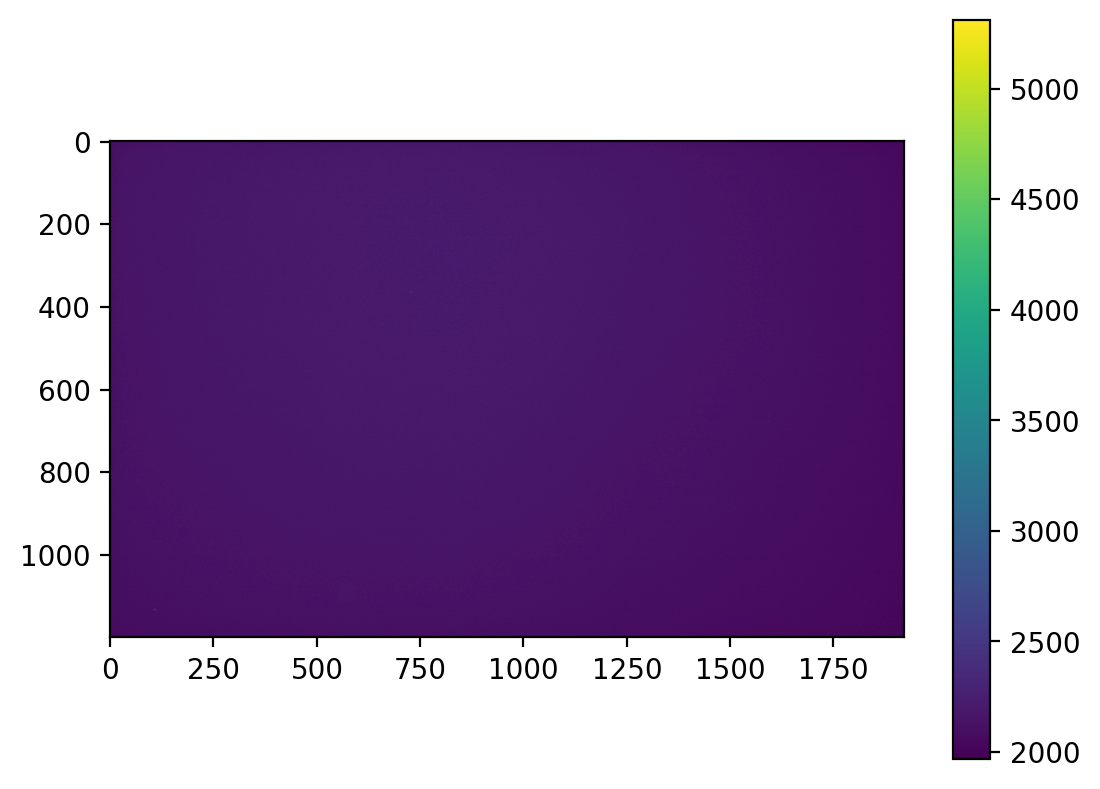

In [104]:
plt.imshow(ims[0])
plt.colorbar()

In [55]:
bg_signal = 1915 # ana has calibrated this for our camera

#subtract all background signal from our images:

ims_bs = ims - bg_signal

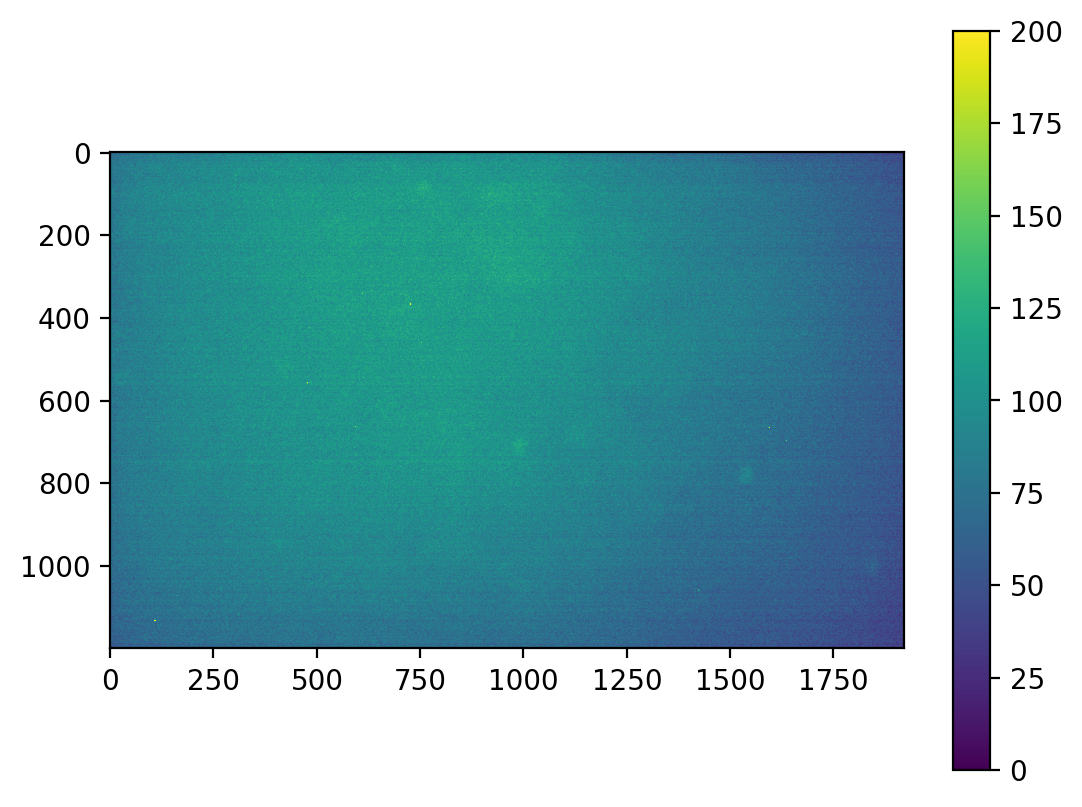

In [67]:
plt.imshow(ims_bs[-1], vmin = 0, vmax = 200)
plt.colorbar()

function to remove uneven illumination

In [58]:
def norm_mat_fn_iATP(im_ref, im_dark, r_blur=3):
    """
    Generate a normalization matrix from a reference image.
    
    This function corrects for uneven illumination. It takes in a reference image which should be the zero 
    ATP control. It then finds the brightest point of the image and for each pixel replaces the pixel value 
    with (brightest pixel value)/(initial pixel value). This creates a matrix that when multiplied by the 
    original image with flatten the illumination and raise every pixel to the brightest value. You can then 
    multiply this normalization matrix by all other images in the dataset to flatten the illumination in each image.

    It is assumed that the reference image is taken for a sample with a spatially uniform protein concentration. The 
    normalization value is everywhere greater than 1, except at the position of the highest illumination.
    
    Parameters
    ----------
    im_ref : numpy array
        Reference image (e.g., the first frame in the MT channel).
    
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    r_blur : float
        Radius of blurring to be performed on the reference image 
        in order to remove noise and short length scale nonuniformities [px].
        
    Returns
    -------
    norm_mat : numpy array
        Normalization matrix
    """
    
    # Convert image into a float type
    im_ref = im_ref.astype(float)
    
    # Subtract the camera offset
    im = im_ref - im_dark
    
    # Rescale the image down for faster denoising
    rescale = 4.0
    im_resized = skimage.transform.rescale(im, 1/rescale)
    
    # Median filter to remove hot pixels
    im_median = skimage.filters.median(im_resized, skimage.morphology.selem.disk(10.0))
    
    # Gaussian blur the image
    im_blur = skimage.filters.gaussian(im_median, r_blur)
    
    # Find the location of the peak
    ind_max = np.where(im_blur == im_blur.max())
    i_center, j_center = ind_max[0][0], ind_max[1][0]
    
    # Peak fluorescence in the normalization image
    fluo_peak = im_blur[i_center, j_center]
    
    # Normalization matrix
    norm_mat = fluo_peak/im_blur 
    
    # Scale up the normalization matrix to the original size
    norm_mat = skimage.transform.rescale(norm_mat, rescale)
    
    return norm_mat

In [61]:
flatoperator = norm_mat_fn_iATP(ims[0], np.ones(np.shape(ims[0]))*bg_signal)

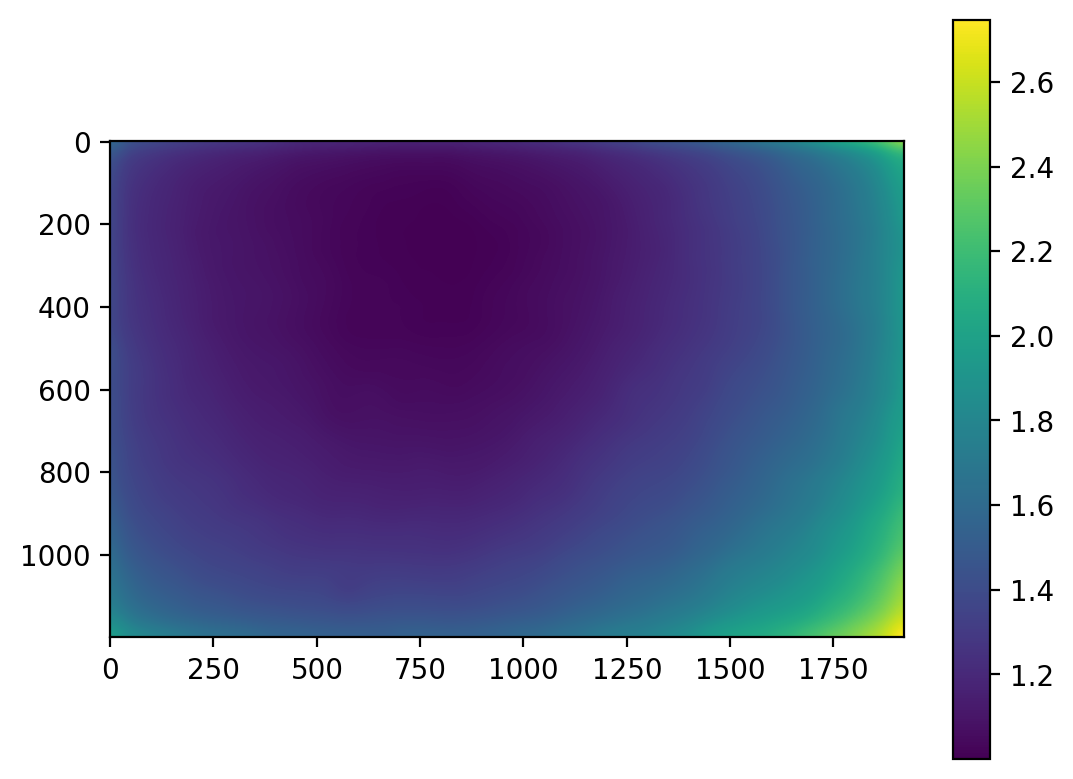

In [62]:
plt.imshow(flatoperator)
plt.colorbar()

In [63]:
ims_flat = ims_bs*flatoperator

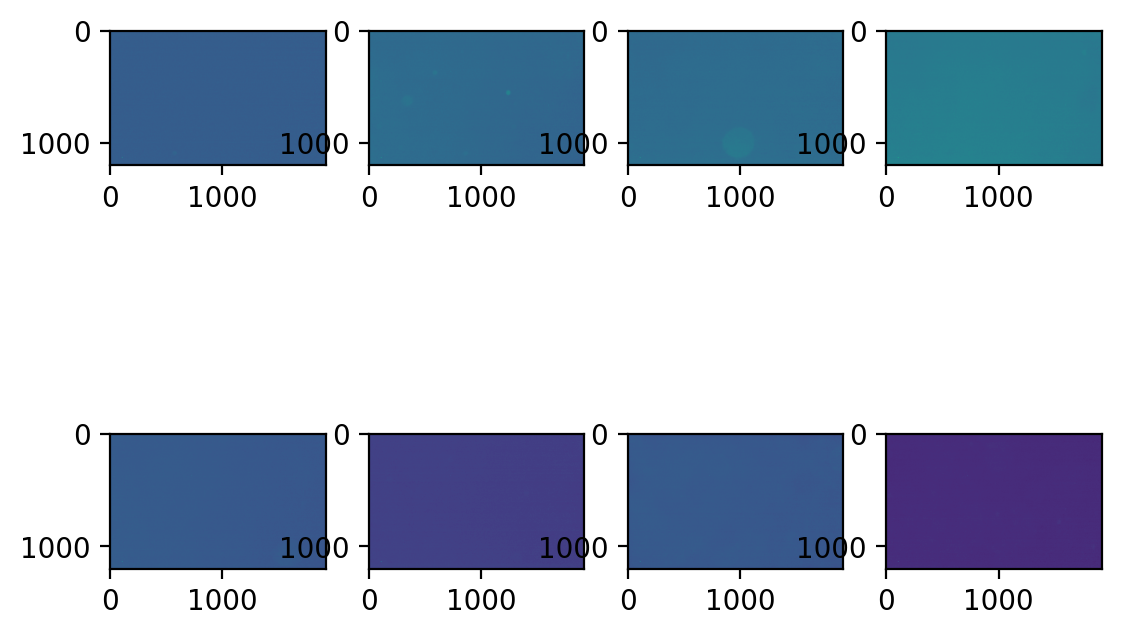

In [75]:
fig, ax = plt.subplots(2, 4)
ax[0][0].imshow(ims_flat[0], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[0][1].imshow(ims_flat[1], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[0][2].imshow(ims_flat[2], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[0][3].imshow(ims_flat[3], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[1][0].imshow(ims_flat[4], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[1][1].imshow(ims_flat[5], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[1][2].imshow(ims_flat[6], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())
ax[1][3].imshow(ims_flat[7], vmin = ims_flat.min(), vmax = 0.2*ims_flat.max())

In [77]:
ims_avg = np.average(ims_flat, axis = (1,2))
ims_avg

array([297.99797714, 349.73099751, 364.80610764, 438.00586656,
       281.29748246, 180.62589731, 277.90729338, 112.00445039])

In [83]:
concs = np.array([2820, 1410, 705, 353, 176, 88, 44, 0])

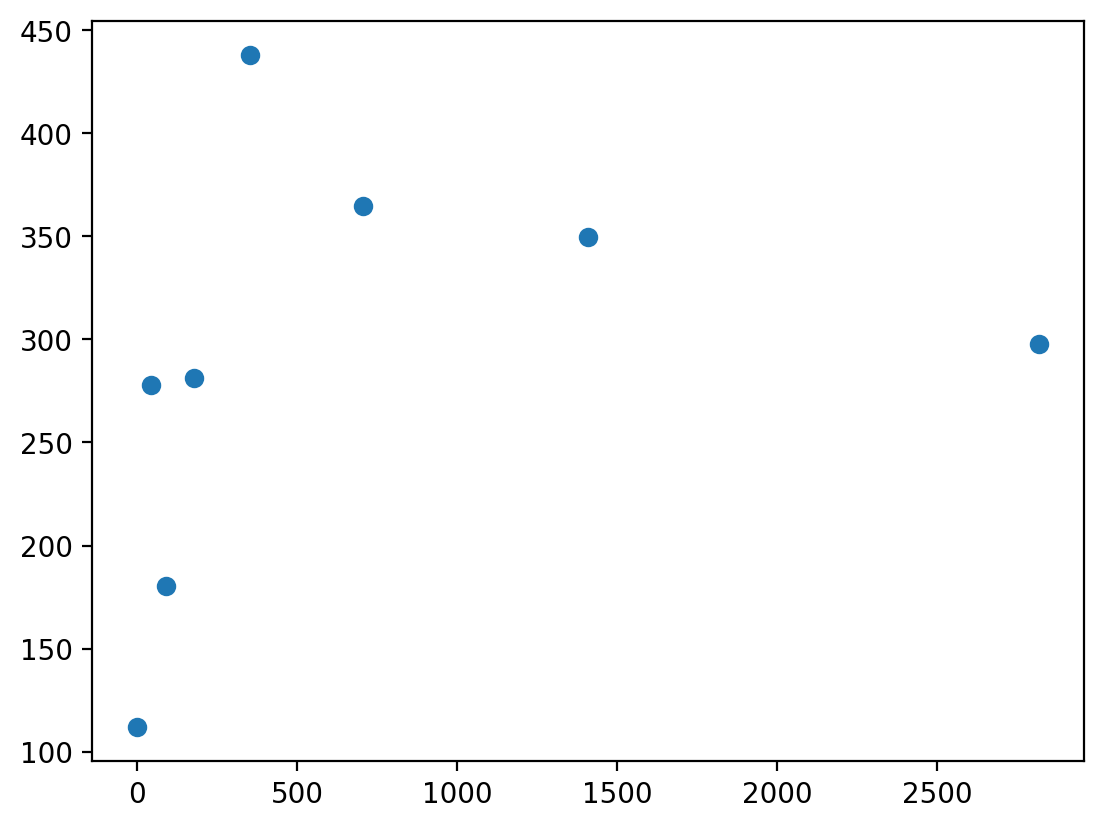

In [85]:
plt.scatter(concs, ims_avg)

In [88]:
def eqn(conc, K, cmin, cmax):
    return (cmax*conc / (K + conc)) + cmin

def fit(eqn, concs, intens, p0):
    params, _ = curve_fit(eqn, concs, intens, p0)
    return params

In [95]:
params = fit(eqn, concs, ims_avg, [100, 100, 400])
params

array([ 53.31354973, 115.33728976, 246.99393686])

In [97]:
conc_vals = np.arange(3000)
conc_vals

solved = eqn(conc_vals, params[0], params[1], params[2])
solved

array([115.33728976, 119.88484628, 124.26797449, ..., 358.01425286,
       358.01566766, 358.01708152])

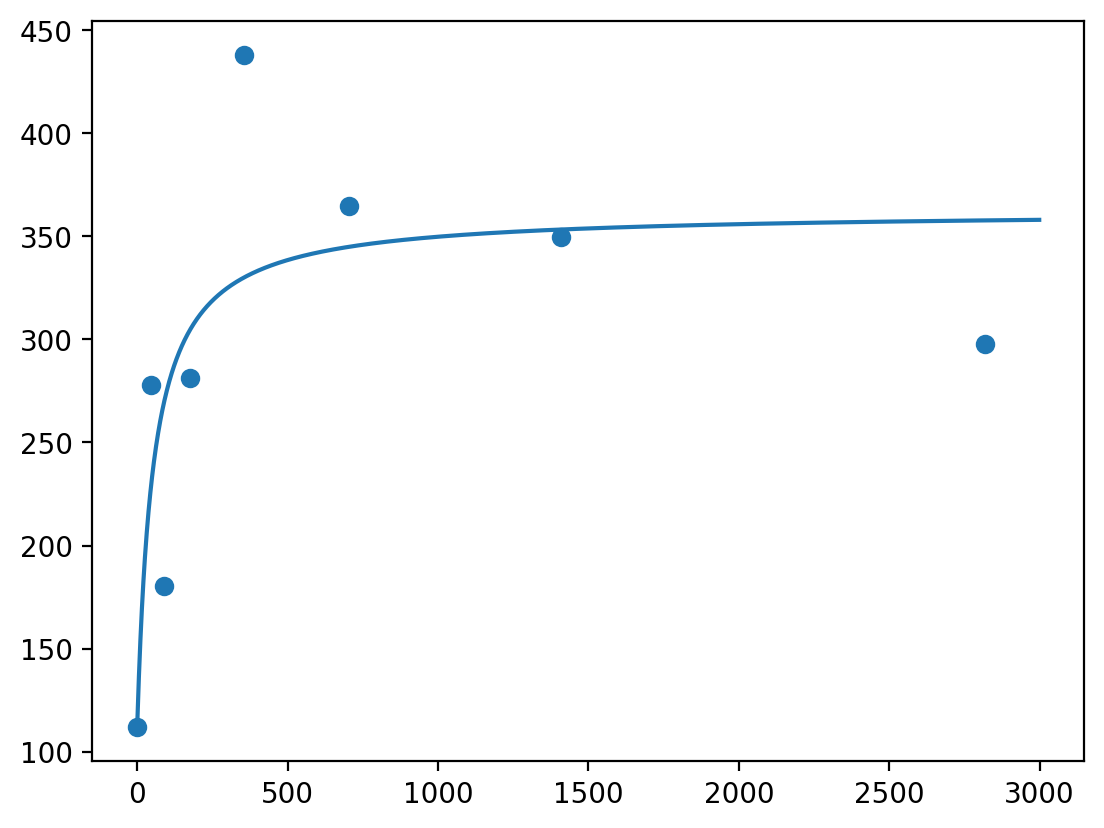

In [99]:
plt.plot(conc_vals, solved)
plt.scatter(concs, ims_avg)

## remove outlier

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[ 57.2177275  120.58361766 218.87943261]')

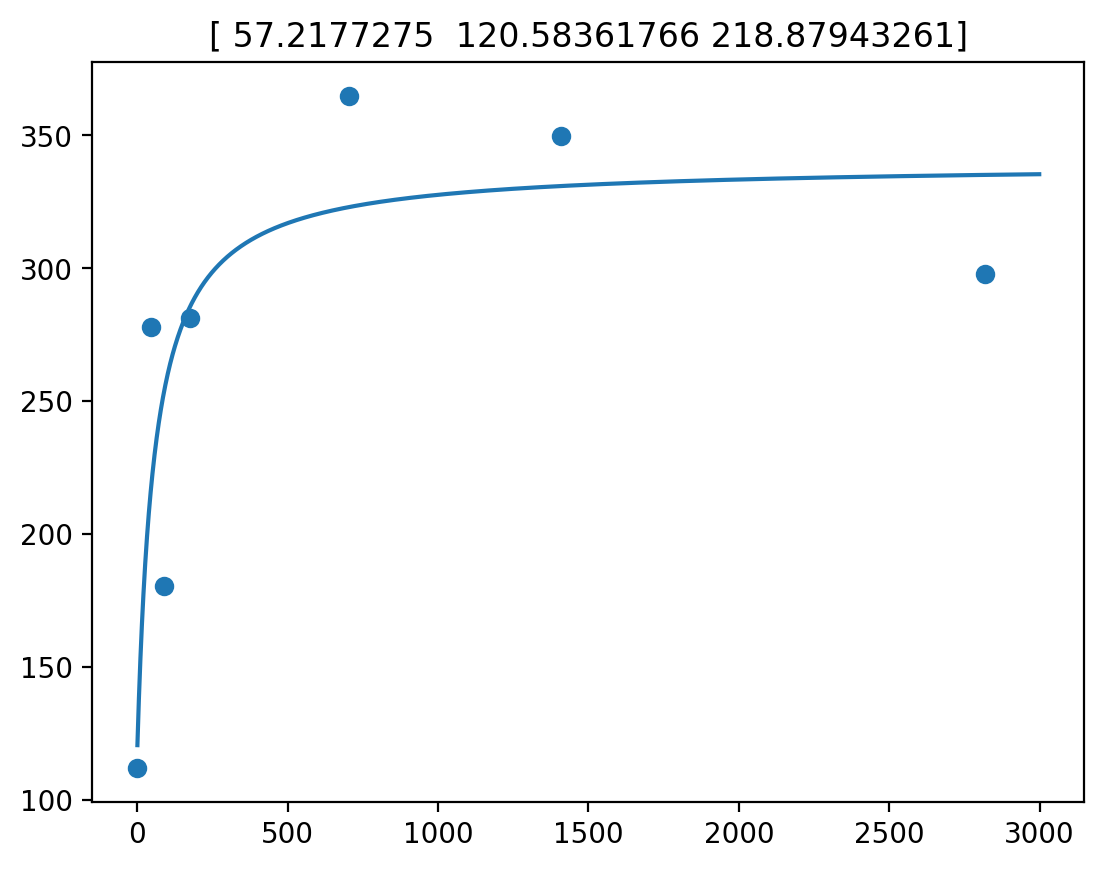

In [103]:
ims_avg_r = np.delete(ims_avg, 3)
concs_r = np.delete(concs, 3)

params_r = fit(eqn, concs_r, ims_avg_r, [100, 100, 400])

conc_vals = np.arange(3000)
solved_r = eqn(conc_vals, params_r[0], params_r[1], params_r[2])

plt.plot(conc_vals, solved_r)
plt.scatter(concs_r, ims_avg_r)
plt.title(params_r)

In [ ]:
def Langmuir_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Langmuir function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(Langmuir, conc, calavg, p0) 

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = Langmuir(xvals, param[0], param[1], param[2])
    
    return param, curve, xvals